# Decoder

## Índice

- [Preparando o ambiente](#prep)
- [Decoder a partir do som emitido pelo celular](#celular)
    - [Captação do sinal](#cap1)
    - [Gráficos](#graficos1)
        - [Sinal no tempo](#tempo1)
        - [Transformada de Fourier](#fourier1)
    - [Identificação da tecla](#ident1)
- [Decoder a partir do arquivo .wav gerado pelo encoder](#wav)
    - [Captação do sinal](#cap2)
    - [Gráficos](#graficos2)
        - [Sinal no tempo](#tempo2)
        - [Transformada de Fourier](#fourier2)
    - [Identificação da tecla](#ident2)

<div id="prep"></div>

___

## Preparando o ambiente

### Importando as bibliotecas

In [1]:
#Importe todas as bibliotecas
from suaBibSignal import *
import peakutils    #alternativas  #from detect_peaks import *   #import pickle
from peakutils.plot import plot as pplot
import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
import time
from scipy.io.wavfile import write

#para ler arquivo .wav
import soundfile as sf

### Definindo funções a serem utilizadas

In [2]:
#converte intensidade em Db, caso queiram ...
def todB(s):
    sdB = 10*np.log10(s)
    return(sdB)

#funcao que dado os picos retorna o numero digitado
def find_number(numbers,pico1,pico2):    
    derro =  5
    for i in numbers.values():
        i.sort()
        if pico1 in range(i[0]-derro,i[0]+derro) and pico2 in range(i[1]-derro,i[1]+derro):
            numero = dict(filter(lambda elem: elem[1] == [i[0],i[1]],numbers.items()))
    for k,v in numero.items():
        print(f"Numero teclado: {k}\nFrequencias: {pico1}Hz e {pico2}Hz")

### Definindo parâmetros e diconário de frequências

In [3]:
signal = signalMeu() 
fs = signal.fs
tempo = signal.time
numCanais = 1

#definido parametros para gravar com a biblio sounddevice
sd.default.samplerate = fs#taxa de amostragem
sd.default.channels = numCanais # o numero de canais
duration =  tempo #tempo em segundos que ira aquisitar o sinal acustico captado pelo mic

#numero de amostras que serao feitas (numero de aquisicoes) durante a gravação
numAmostras = tempo*fs

#dicionario com as frequencias para posterior verificacao
numbers = {"1":[1209,697],
"2": [1336,697],
"3": [1477,697],
"A": [1633,697],
"4": [1209,770],
"5": [1336,770],
"6": [1477,770],
"B": [1633,770],
"7": [1209,852],
"8": [1336,852],
"9": [1477,852],
"C": [1633,852],
"X": [1209,941],
"0": [1336,941],
"#": [1477,941],
"D": [1633,941],
}

<div id="celular"></div>

___

## Decoder a partir do som emitido pelo celular
Nessa etapa poderá ser captado o sinal de áudio emitido pelo seu celular através do microfone.

Para isso, basta aproximar o celular do microfone e digitar a tecla ao iniciar a gravacao.

<div id="cap1"></div>


### Iniciando a captação

In [4]:
print("A captacao comecará em 2 segundos . . . \n")
time.sleep(2)

print("A gravacao foi iniciada")

#gravacao
audio = sd.rec(int(numAmostras), fs, channels=1)
sd.wait()
write('audio/output.wav', fs, audio)
print("...     FIM")


A captacao comecará em 2 segundos . . . 

A gravacao foi iniciada
...     FIM


Abaixo foi feita uma conversão do formato do array para que fosse possível o cálculo da transformada de Fourier

In [5]:
dados1 = np.ndarray(shape=(132300,),dtype=np.float32)
for i in range(0,dados1.shape[0]):
    dados1[i] = audio[i][0]

Verifique abaixo se o som da tecla foi captado. Se não, execute a célula de captação novamente

In [6]:
sd.play(dados1, fs)
sd.wait(duration)

<div id="graficos1"></div>

___

### Gerando os gráficos

<div id="tempo1"></div>

* **Gráfico do sinal recebido no tempo**

In [7]:
x = np.linspace(0.0, tempo, numAmostras)

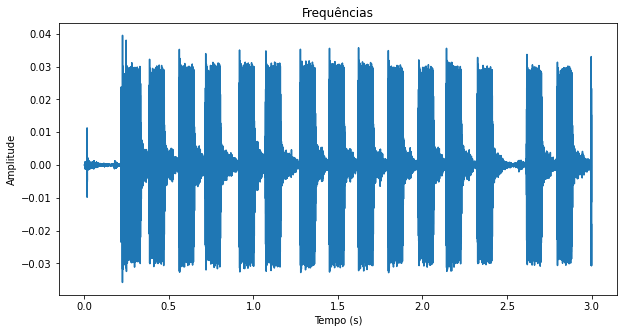

In [8]:
maxt=(1e-2)
fig = plt.figure(figsize=(10, 5))
#plt.xlim([1, 1.2+maxt])
plt.plot(x,audio)
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.title('Frequências')

plt.show()

<div id="fourier1"></div>


* **Gráficos da Transformada de Fourier do sinal recebido**

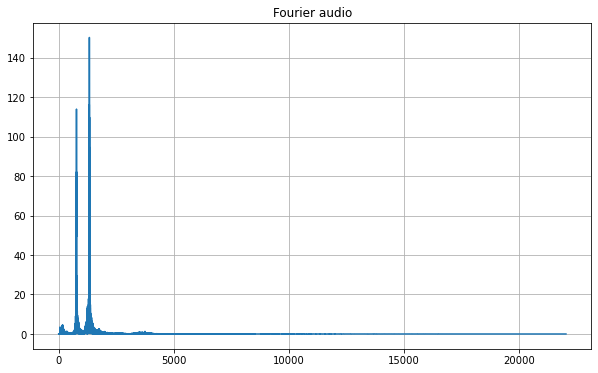

In [9]:
signal.plotFFT(dados1,fs)

Podemos observar com esse gráfico a presença de dois picos eminentes. A partir desses picos, podemos verificar qual número foi teclado a partir das suas frequencias. Os valores da frequencia de cada pico podem ser melhores observadas no gráfico abaixo.


**Obs**: "thres" determina a sensibilidade da funcao, ou seja, quão elevado tem que ser o valor do pico para de fato ser considerado um pico. Logo, caso não seja identificado apenas 1 dos picos, diminua o valor de thres adequadamente

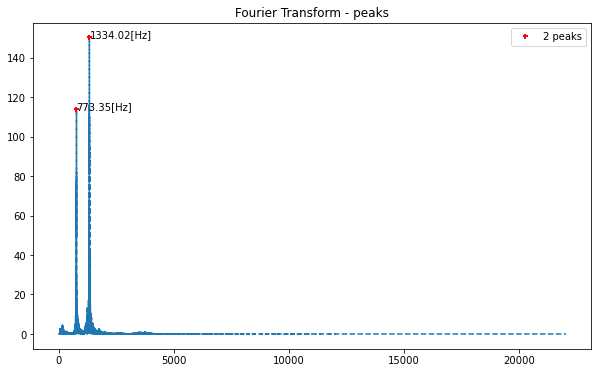

In [10]:
x1, y1 = signal.calcFFT(dados1, fs)

index1 = peakutils.indexes(y1, thres=0.4, min_dist=1000)

signal.plot_fourier_peaks(x1,y1,index1)

<div id="ident1"></div>



### Identificação da tecla

Fazendo a correspondencia com os dados da tabela seguinte, é possível identificar o número. A função find_number é responsável por realizar essa correspondência

<img src="img/tabela.png">

In [11]:
pico1_1 = int(x1[index1][0])
pico2_1 = int(x1[index1][1])
find_number(numbers,pico1_1,pico2_1)

Numero teclado: 5
Frequencias: 773Hz e 1334Hz


<div id="wav"></div>

___

## Decoder a partir do arquivo .wav gerado pelo encoder
Nessa etapa poderá ser captado o sinal de áudio gerado e salvo pelo encoder no arquivo `audio/input.wav` através do microfone do próprio computador.

Assim, o código irá tocar e gravar o sinal emitido simultaneamente 

<div id="cap2"></div>


### Captando o sinal gerado

In [12]:
#https://realpython.com/playing-and-recording-sound-python/

In [13]:
filepath = "audio/input.wav"
data, fs = sf.read(filepath, dtype='float32')  
myrecording = sd.playrec(data, fs, channels=1)

Rearranjando o array gerado para calcular a transformada

In [14]:
dados2 = np.ndarray(shape=(132300,),dtype=np.float32)
for i in range(0,dados2.shape[0]):
    dados2[i] = myrecording[i][0]

<div id="graficos2"></div>


### Gerando os gráficos


<div id="tempo2"></div>

* **Gráfico do sinal recebido no tempo**

In [15]:
x = np.linspace(0.0, tempo, numAmostras)

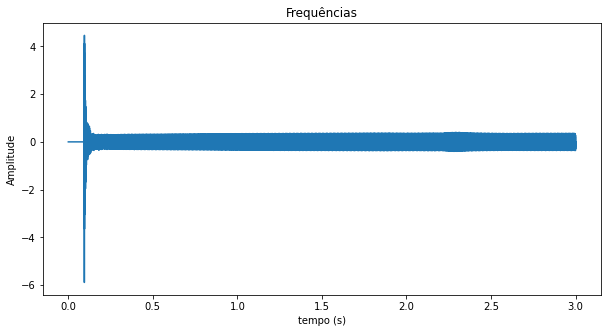

In [16]:
maxt=(1e-2)
fig = plt.figure(figsize=(10, 5))
#plt.xlim([1, 1+maxt])
plt.plot(x,dados2)
plt.xlabel("tempo (s)")
plt.ylabel("Amplitude")
plt.title('Frequências')

plt.show()

<div id="fourier2"></div>


* **Gráficos da Transformada de Fourier do sinal recebido**

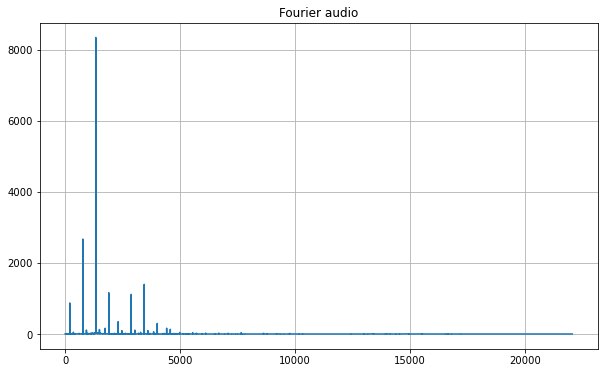

In [17]:
signal.plotFFT(dados2,fs)
x2, y2 = signal.calcFFT(dados2, fs)

In [20]:
index2 = peakutils.indexes(y2, thres=0.2, min_dist=1000)

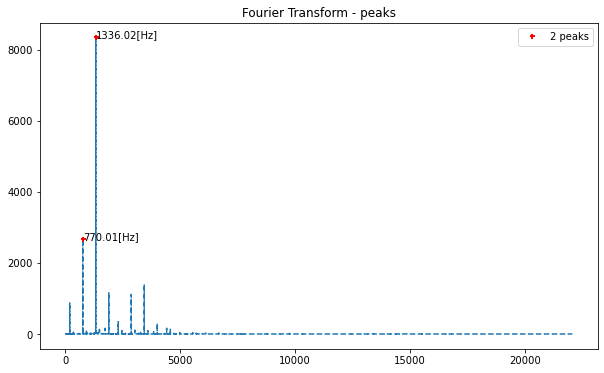

In [21]:
signal.plot_fourier_peaks(x2,y2,index2)

<div id="ident2"></div>


### Indentificação da tecla


In [22]:
pico1_2 = int(x2[index2][0])
pico2_2 = int(x2[index2][1])
find_number(numbers,pico1_2,pico2_2)

Numero teclado: 5
Frequencias: 770Hz e 1336Hz
